### Analyzie coeffficient of partial determination for entire population, and split by regions

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

In [16]:
OUTPUT_DIR = "/data/patrick_res/glm"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
ALPHA = 0.05
sessions = pd.read_pickle(SESSIONS_PATH)

In [17]:
# REGION = "Hippocampus/MTL"
# REGION = "hippocampal_formation (HF)"
REGION = "orbital_frontal_cortex (OFC)"
units = spike_utils.get_unit_positions(sessions)
# region_units = units
# region_units = units[units.manual_structure == REGION]
# region_units = units[units.structure_level3 == REGION]
region_units = units[units.structure_level2 == REGION]

In [18]:
def get_res_per_session(row):
    session = row.session_name
    separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_separate.pickle"))
    separate_res["TimeIdxs"] = (separate_res["TimeBins"] * 10).astype(int)
    separate_res = separate_res.rename(columns={"score": "separate_score"})

    interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
    interaction_res["TimeIdxs"] = (interaction_res["TimeBins"] * 10).astype(int)
    interaction_res = interaction_res.rename(columns={"score": "interaction_score"})

    shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    shuffled_res["TimeIdxs"] = (shuffled_res["TimeBins"] * 10).astype(int)

    sig_stats = glm_utils.calculate_sig_stats(shuffled_res, ALPHA, 1)
    sig_stats["TimeIdxs"] = (sig_stats["TimeBins"] * 10).astype(int)

    merged = pd.merge(separate_res, interaction_res, on=["UnitID", "TimeIdxs"])
    merged = pd.merge(merged, sig_stats, on=["UnitID", "TimeIdxs"])

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    with_pos = pd.merge(merged, pos, on=["UnitID"])
    with_pos["PseudoUnitID"] = int(session) * 100 + with_pos["UnitID"]
    return with_pos[["PseudoUnitID", "TimeBins", "TimeIdxs", "separate_score", "interaction_score", "sig_bound", "manual_structure"]]

In [19]:
unit_res = pd.concat(sessions.apply(get_res_per_session, axis=1).values).reset_index(drop=True)
# unit_res = unit_res[unit_res.PseudoUnitID.isin(region_units.PseudoUnitID)]

In [20]:
unit_res["additional_score"] = 1 - (1 - unit_res["interaction_score"]) / (1 - unit_res["separate_score"])
unit_res["sig_additional_score"] = 1 - (1 - unit_res["sig_bound"]) / (1 - unit_res["separate_score"])

In [21]:
unit_res

,PseudoUnitID,TimeBins,TimeIdxs,separate_score,interaction_score,sig_bound,manual_structure,additional_score,sig_additional_score
0,2018070900,0.0,0,0.001616,0.002738,0.003115,Claustrum,0.001123,0.001501
1,2018070900,0.1,1,0.000890,0.002007,0.002342,Claustrum,0.001119,0.001453
2,2018070900,0.2,2,0.000958,0.002170,0.002562,Claustrum,0.001214,0.001606
3,2018070900,0.3,3,0.000676,0.001480,0.002154,Claustrum,0.000804,0.001479
4,2018070900,0.4,4,0.001360,0.002736,0.002956,Claustrum,0.001377,0.001597
...,...,...,...,...,...,...,...,...,...
21163,2018091029,2.3,23,0.002421,0.004431,0.004312,Amygdala,0.002015,0.001895
21164,2018091029,2.4,24,0.001748,0.003260,0.003523,Amygdala,0.001515,0.001778
21165,2018091029,2.5,25,0.002785,0.004978,0.004337,Amygdala,0.002199,0.001556
21166,2018091029,2.6,26,0.001594,0.003131,0.003128,Amygdala,0.001539,0.001537


/tmp/ipykernel_3684483/2048988401.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeBins").mean().reset_index()
/tmp/ipykernel_3684483/2048988401.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeBins").mean().reset_index()
/tmp/ipykernel_3684483/2048988401.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeBins").mean

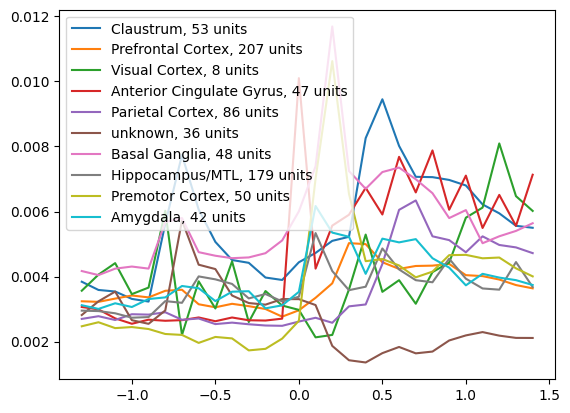

In [22]:
fig, ax = plt.subplots()
time = np.arange(-1.3, 1.5, 0.1)

for region in unit_res.manual_structure.unique():
    region_res = unit_res[unit_res.manual_structure == region]
    avged = region_res.groupby("TimeBins").mean().reset_index()
    ax.plot(time, avged.additional_score, label=f"{region}, {len(region_res.PseudoUnitID.unique())} units")
ax.legend()


In [63]:
avged = unit_res.groupby("TimeBins")["additional_score", "sig_additional_score"].mean().reset_index()

/tmp/ipykernel_3629507/3452084166.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avged = unit_res.groupby("TimeBins")["additional_score", "sig_additional_score"].mean().reset_index()


Text(0.5, 1.0, 'orbital_frontal_cortex (OFC), 18 units')

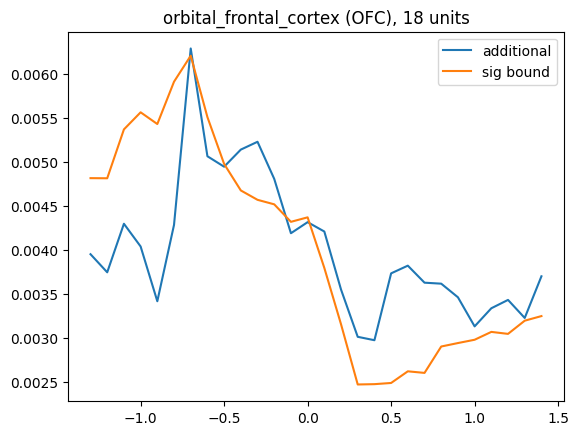

In [56]:
fig, ax = plt.subplots()
time = np.arange(-1.3, 1.5, 0.1)
ax.plot(time, avged.additional_score, label="additional")
ax.plot(time, avged.sig_additional_score, label="sig bound")
ax.legend()
ax.set_title(f"{REGION}, {len(unit_res.PseudoUnitID.unique())} units")